In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
from sklearn.utils import resample
import openpyxl

from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.chart import BarChart, Reference

## Data cleaning

In [2]:
#loading data
df = pd.read_csv(r'C:\Users\Yuva S Korlaband\Downloads\VCM ML Model\VCM ML Model\vcm_model_data.csv')
df.info()

In [3]:
filtered_df = df[df['Market Segment'] == 'Intermediary']

# Calculate the median of the 'Transaction_volumn' column in the filtered DataFrame
median_value = filtered_df['Transaction_Volume'].median()

# Print the median value
print("Median Transaction Volume for Retail market segment:", median_value)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4796 entries, 0 to 4795
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date_of_Trade          4796 non-null   object
 1   Price_of_Trade         4796 non-null   object
 2   Transaction_Volume     4796 non-null   int64 
 3   Delivery_Year          4795 non-null   object
 4   Vintage Year           4689 non-null   object
 5   Region_of_Origin       4778 non-null   object
 6   Protocol_Type          4796 non-null   object
 7   Verification_Standard  4775 non-null   object
 8   Market Segment         4796 non-null   object
dtypes: int64(1), object(8)
memory usage: 337.3+ KB


In [4]:
#error handling
df['Vintage Year'] = pd.to_datetime(df['Vintage Year'], errors='coerce')
df['Delivery_Year'] = pd.to_datetime(df['Delivery_Year'], errors='coerce')
df['Date_of_Trade'] = pd.to_datetime(df['Date_of_Trade'], errors='coerce')
df['Vintage Year'] = (df['Vintage Year'].dt.year)
df['Delivery_Year'] = (df['Delivery_Year'].dt.year)

Median Transaction Volume for Retail market segment: 6884.0


In [5]:
# reference date handling 
reference_date = pd.to_datetime("2005-01-01")
df['Date_of_Trade'] = (df['Date_of_Trade'] - reference_date).dt.days + 1

In [6]:
# handling empty values
df = df[df['Protocol_Type'] != 'TBD']
df = df[df['Verification_Standard'] != 'TBD']
df['Region_of_Origin'] = df['Region_of_Origin'].replace('TBD',np.nan)
df['Protocol_Type'] = df['Protocol_Type'].replace('TBD',np.nan)
df['Verification_Standard'] = df['Verification_Standard'].replace('TBD',np.nan)

In [7]:
# handling non available price rows
df['Price_of_Trade'] = pd.to_numeric(df['Price_of_Trade'], errors='coerce')
df = df.dropna()

In [8]:
# protocol category mapping
protocol_category_mapping = {
    "Af / Re-Forestation": "Others",
    "Land Use - Avoidance": "Others",
    "Other Tech Solutions": "Others",
    "Cookstove": "Others",
    "Biomass": "Others",
    "Other Greenhouse Gases": "Others",
    "Land Use - Removal": "Others"
}
df['Protocol_Type'] = df['Protocol_Type'].replace(protocol_category_mapping)

In [9]:
# handling outliers
df['Transaction_Volume'] = pd.to_numeric(df['Transaction_Volume'], errors='coerce')
df = df[df['Price_of_Trade'] <= 40]
df = df[df['Transaction_Volume'] <= 1592501]

# Data preparation

In [11]:
columns_to_encode = ['Protocol_Type','Verification_Standard',
                     'Region_of_Origin','Market Segment']

In [12]:
df_encoding =pd.get_dummies(df,columns=columns_to_encode)

In [13]:
numeric_columns = ['Transaction_Volume','Date_of_Trade','Delivery_Year','Vintage Year']
price_column  = ['Price_of_Trade']

      Date_of_Trade  Price_of_Trade  Transaction_Volume  Delivery_Year  \
0            1775.0            16.0                 864         2010.0   
1            1593.0            11.0                 275         2011.0   
3            2162.0             5.0               26053         2011.0   
4            2162.0             5.0                5247         2011.0   
6            1832.0             7.0               35000         2011.0   
...             ...             ...                 ...            ...   
4788         6823.0             2.8                 250         2023.0   
4791         6823.0             3.0                  50         2023.0   
4793         6823.0             1.8                 500         2023.0   
4794         6580.0             6.0                 687         2023.0   
4795         6823.0             2.5                  50         2023.0   

      Vintage Year Region_of_Origin     Protocol_Type Verification_Standard  \
0           2008.0    North Amer

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_encoding[numeric_columns] = scaler.fit_transform(df_encoding[numeric_columns])
price_scaler = MinMaxScaler(feature_range=(0,1))
df_encoding[price_column] = price_scaler.fit_transform(df_encoding[price_column])

In [30]:
X = df_encoding.drop(['Price_of_Trade'], axis=1)
y = df_encoding['Price_of_Trade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=1234, stratify=None)

['D:\\price_model_scaler.joblib']

## Model Building

In [16]:
model = XGBRegressor(
    objective='reg:tweedie', 
    booster='gbtree',
    learning_rate=0.1,              
    max_depth=6,                    
    subsample=0.8,                  
    colsample_bytree=0.6,
    gamma=0.3,
    min_child_weight=5,
    n_estimators=500 ,
    random_state=1234
)

In [17]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

['D:\\xgboost_model.joblib']

In [21]:
xgb_params = {
    'objective': 'reg:tweedie', 
    'booster': 'gbtree',
    'learning_rate': 0.1,              
    'max_depth': 6,                    
    'subsample': 0.8,                  
    'colsample_bytree': 0.6,
    'gamma': 0.3,
    'min_child_weight': 5,
    'n_estimators': 500,
    'random_state': 1234
}

num_models = 100

sampling_size = 0.93

models = []

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
for i in range(num_models):
    indices = np.random.choice(len(X_train), size=int(len(X_train) * sampling_size), replace=True)
    model = XGBRegressor(**xgb_params)
    model.fit(X_train.iloc[indices], y_train.iloc[indices])
    models.append(model)
    locals()[f"model_{i+1}"] = model


## Feature Importance

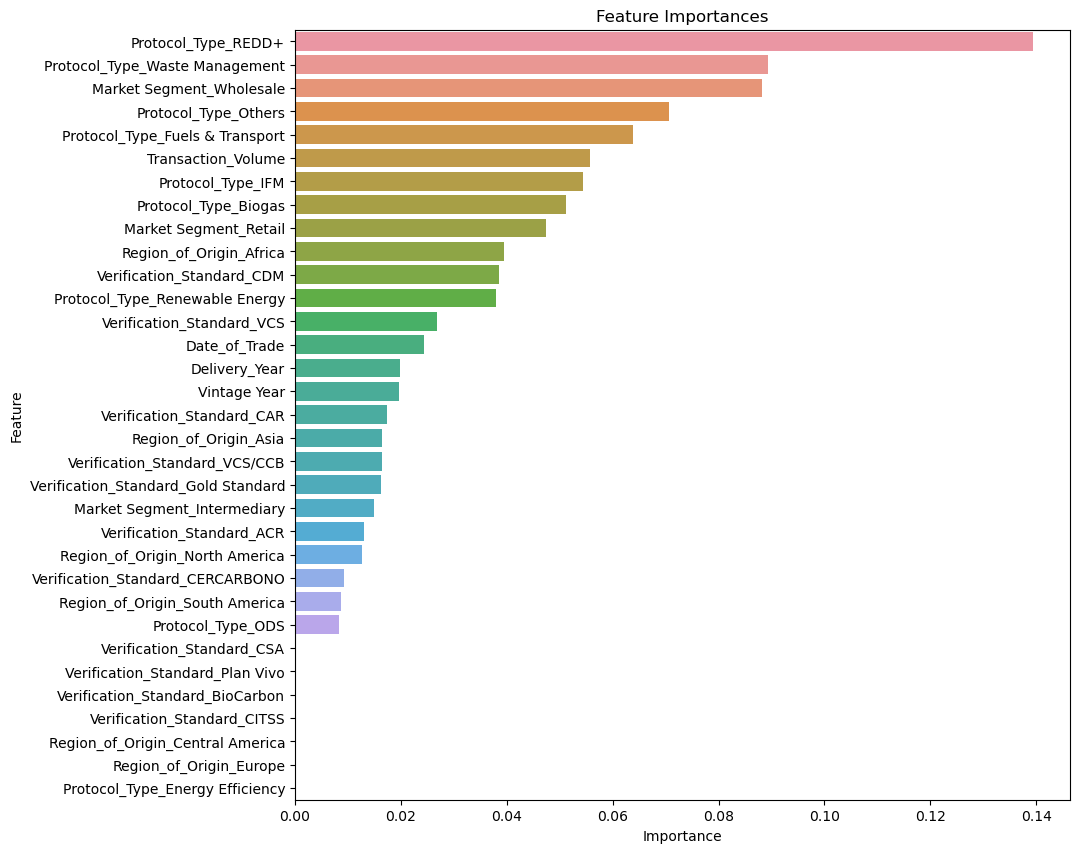

In [25]:
importances = model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
feature_importance_chart = sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Predictions

In [26]:
data = pd.read_excel(r'C:\Users\Yuva S Korlaband\Downloads\VCM ML Model\VCM ML Model\VCM_Price_Inputs.xlsx')

In [27]:
data.head()

,Date_of_Trade,Transaction_Volume,Delivery_Year,Protocol_Type,Verification_Standard,Region,Vintage Year,Market Segment,Price_of_Trade,lower_interval,upper_interval
0,2023-10-27,50000,2023-10-27,REDD+,VCS,South America,2018-12-31,Retail,NaN,NaN,NaN
1,2022-10-27,50000,2022-10-27,REDD+,VCS,South America,2017-12-21,Retail,NaN,NaN,NaN
2,2023-10-27,500000,2023-10-27,REDD+,VCS,South America,2018-12-31,Retail,NaN,NaN,NaN
3,2023-10-27,50000,2023-10-27,REDD+,VCS,South America,2018-12-31,Wholesale,NaN,NaN,NaN
4,2023-10-27,50000,2023-10-27,REDD+,VCS,Africa,2018-12-31,Retail,NaN,NaN,NaN


In [55]:
data['Vintage Year'] = pd.to_datetime(data['Vintage Year'], errors='coerce')
data['Delivery_Year'] = pd.to_datetime(data['Delivery_Year'], errors='coerce')
data['Date_of_Trade'] = pd.to_datetime(data['Date_of_Trade'], errors='coerce')
data['Vintage Year'] = data['Vintage Year'].dt.year
data['Delivery_Year'] = data['Delivery_Year'].dt.year
data['Date_of_Trade'] = (data['Date_of_Trade'] - pd.to_datetime('2005-01-01')).dt.days

numeric_columns2 = ['Transaction_Volume','Date_of_Trade','Delivery_Year','Vintage Year']

In [28]:
for index, row in data.iterrows():
    print(row)
    print('------------------')

Date_of_Trade            2023-10-27 00:00:00
Transaction_Volume                     50000
Delivery_Year            2023-10-27 00:00:00
Protocol_Type                          REDD+
Verification_Standard                    VCS
Region                         South America
Vintage Year             2018-12-31 00:00:00
Market Segment                        Retail
Price_of_Trade                           NaN
lower_interval                           NaN
upper_interval                           NaN
Name: 0, dtype: object
------------------
Date_of_Trade            2022-10-27 00:00:00
Transaction_Volume                     50000
Delivery_Year            2022-10-27 00:00:00
Protocol_Type                          REDD+
Verification_Standard                    VCS
Region                         South America
Vintage Year             2017-12-21 00:00:00
Market Segment                        Retail
Price_of_Trade                           NaN
lower_interval                           NaN
upper_interva

In [57]:
for index, row in data.iterrows():
    
    row_subset = row[:8]
    row_dict = row_subset.to_dict()
    
    for col in ['Protocol_Type', 'Verification_Standard', 'Region', 'Market Segment']:
        new_col_name = f"{col}_{row_dict[col]}"
        row_dict[new_col_name] = 1
    
    input_data = pd.DataFrame([row_dict])  

    input_df = pd.DataFrame(input_data)

    input_df[numeric_columns2] = scaler.transform(input_df[numeric_columns2])
    
    missing_columns = set(X_test.columns) - set(input_df.columns)

    for col in missing_columns:
        input_df[col] = 0

    X_test_columns_order = X_test.columns.tolist()
    input_df = input_df[X_test_columns_order]
    
    price = model.predict(input_df)
    price_scale_reshaped = price.reshape(1, -1)
    predicted_prices = price_scaler.inverse_transform(price_scale_reshaped)
    data.at[index, 'Price_of_Trade'] = predicted_prices[0][0]
    #print(input_df)
    print(predicted_prices)
    
    #Insert bootstrap here
    #confidence interval
    predicted_prices = []

    for i, model in enumerate(models):
        predicted_price = model.predict(input_df)
        predicted_prices.append(predicted_price)

        #print(f"Predicted price using model_{i+1}: {predicted_price}")

    predicted_prices = np.array(predicted_prices)

    min_price = np.min(predicted_prices)
    max_price = np.max(predicted_prices)

    predicted_prices = np.array(predicted_prices)
    inverse_scaled_prices = price_scaler.inverse_transform(predicted_prices)

    percentile_5 = np.percentile(inverse_scaled_prices, 5)
    percentile_95 = np.percentile(inverse_scaled_prices, 95)

    min_price = np.min(inverse_scaled_prices)
    max_price = np.max(inverse_scaled_prices)
    
    data.at[index, 'lower_interval'] = min_price
    data.at[index, 'upper_interval'] = max_price

data['Date_of_Trade'] = pd.to_timedelta(data['Date_of_Trade'], unit='D') + pd.Timestamp('2005-01-01')
data['Date_of_Trade'] = data['Date_of_Trade'].dt.strftime('%d-%m-%Y')
output_sheet_name = 'Output'

with pd.ExcelWriter(r'C:\Users\Yuva S Korlaband\Downloads\VCM ML Model\VCM ML Model\VCM_Price_Inputs.xlsx', engine='openpyxl', mode='a') as writer:

    if output_sheet_name in writer.book.sheetnames:

        existing_sheet = writer.book[output_sheet_name]
        start_row = existing_sheet.max_row + 1
        data.to_excel(writer, sheet_name=output_sheet_name, index=False, startrow=start_row)
    else:

        data.to_excel(writer, sheet_name=output_sheet_name, index=False)   



[[8.157141]]
[[11.113991]]
[[7.543897]]
[[9.855888]]
[[8.157141]]
[[4.649717]]
[[5.1099358]]
[[3.0347457]]
[[4.649717]]
[[4.831406]]
[[4.831406]]
[[5.309606]]
[[4.831406]]
[[4.831406]]
[[5.227195]]
[[4.7469454]]


## Pickling

In [80]:
import joblib

joblib.dump(model, r'D:\xgboost_model.joblib')
joblib.dump(scaler, r'D:\model_scaler.joblib')
joblib.dump(price_scaler,r'D:\price_model_scaler.joblib')
joblib.dump(X_test,r'D:\X_test.joblib')
joblib.dump(models, r'D:\interval_models.joblib')

,Date_of_Trade,Transaction_Volume,Delivery_Year,Protocol_Type,Verification_Standard,Region,Vintage Year,Market Segment,Price_of_Trade,lower_interval,upper_interval
0,2013-12-31,5000,2013,Waste Management,CAR,South America,2013,Retail,3.656235,2.896072,7.943925
1,2014-03-31,5000,2014,Waste Management,CAR,South America,2014,Retail,3.772033,2.968546,8.290069
